In [176]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import math
import warnings
warnings.filterwarnings('ignore')

# Utils

In [177]:
def print_logerror(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc.values))
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc.values))
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc.values)))
    mape = np.mean(np.abs(np.exp(fc.values) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('RMSE: ', rmse)
    print('MAPE: {:.2f}%'.format(mape*100))

In [205]:
def print_error(test_data, fc):
    mse = mean_squared_error(test_data, fc.values)
    mae = mean_absolute_error(test_data,fc.values)
    rmse = math.sqrt(mean_squared_error(test_data, fc.values))
    mape = np.mean(np.abs(fc.values - test_data)/np.abs(test_data))
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('RMSE: ', rmse)
    print('MAPE: {:.2f}%'.format(mape*100))

In [179]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [180]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Apple

In [181]:
df = fdr.DataReader('AAPL', '2017')
ts = df['Close']
ts.head()

Date
2017-01-03    29.037500
2017-01-04    29.004999
2017-01-05    29.152500
2017-01-06    29.477501
2017-01-09    29.747499
Name: Close, dtype: float64

In [182]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [183]:
ts_log = np.log(ts)

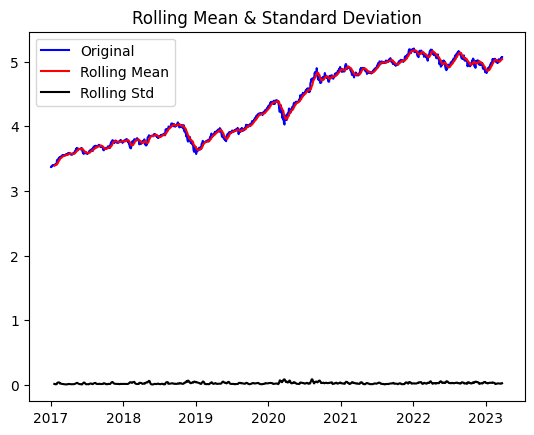

Results of Dickey-Fuller Test:
Test Statistic                   -1.108477
p-value                           0.711680
#Lags Used                        9.000000
Number of Observations Used    1556.000000
Critical Value (1%)              -3.434560
Critical Value (5%)              -2.863399
Critical Value (10%)             -2.567760
dtype: float64


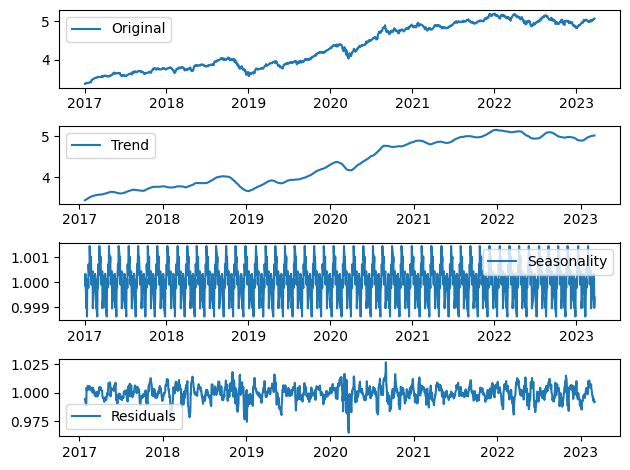

In [184]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

계절성과 트렌드를 모두 가지고 있다. adf검정 결과도 정상성을 만족하지 못한다고 나온다.

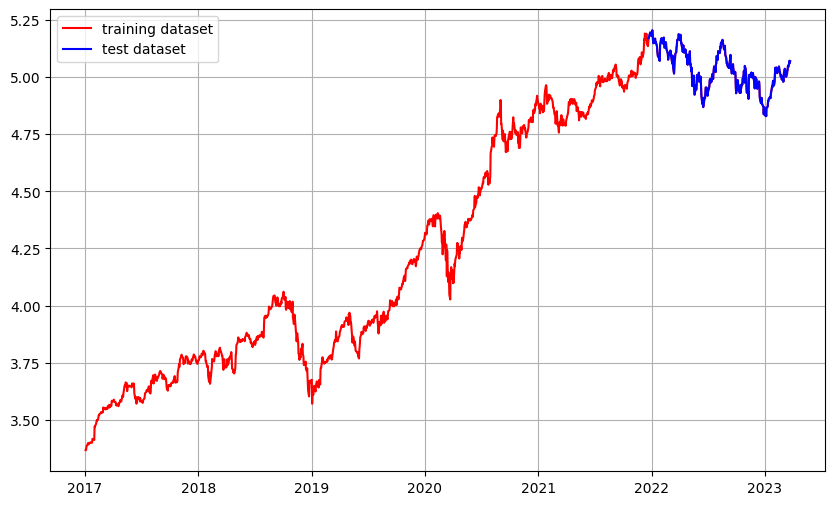

In [186]:
train_data, test_data =  ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

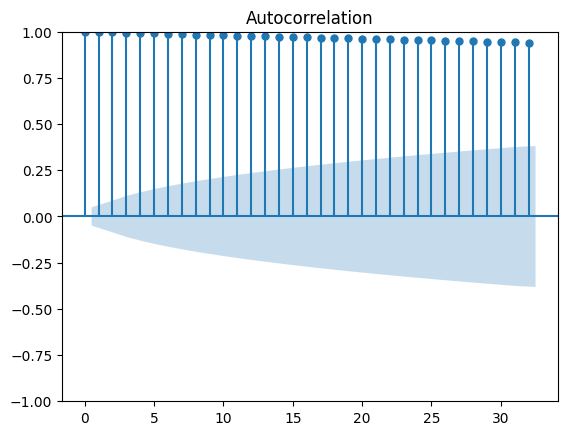

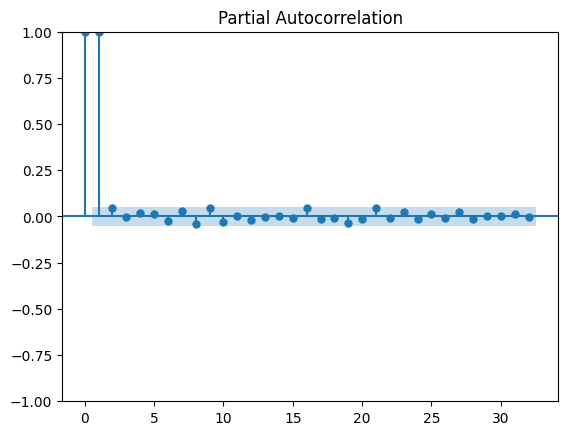

In [187]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

autocorrelation이 점진적으로 감소하는 형태이기 때문에 P를 결정할 수 없다.
partial autocorrelation을 봤을때 Q는 2가 적당해 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.235347e+01
p-value                        5.755682e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.556000e+03
Critical Value (1%)           -3.434560e+00
Critical Value (5%)           -2.863399e+00
Critical Value (10%)          -2.567760e+00
dtype: float64


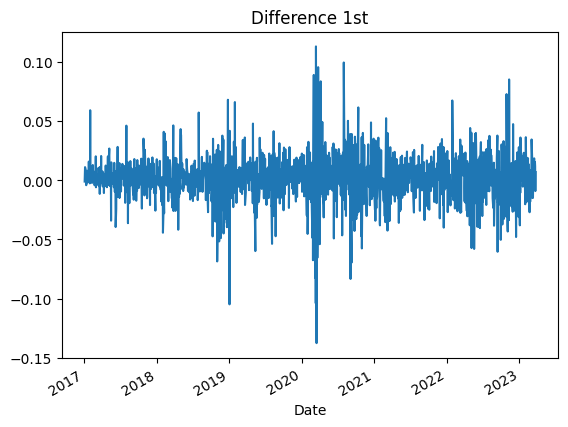

In [193]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

계절성이 있기 때문에 차분해주면 정상성을 만족하는것을 볼 수 있다.

In [190]:

# Build and Train  Model
model = ARIMA(train_data, order=(0,1,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1252
Model:                 ARIMA(0, 1, 2)   Log Likelihood                3173.683
Date:                Fri, 24 Mar 2023   AIC                          -6341.366
Time:                        12:46:42   BIC                          -6325.971
Sample:                             0   HQIC                         -6335.579
                               - 1252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1223      0.018     -6.925      0.000      -0.157      -0.088
ma.L2          0.0338      0.016      2.139      0.032       0.003       0.065
sigma2         0.0004   7.75e-06     47.276      0.0

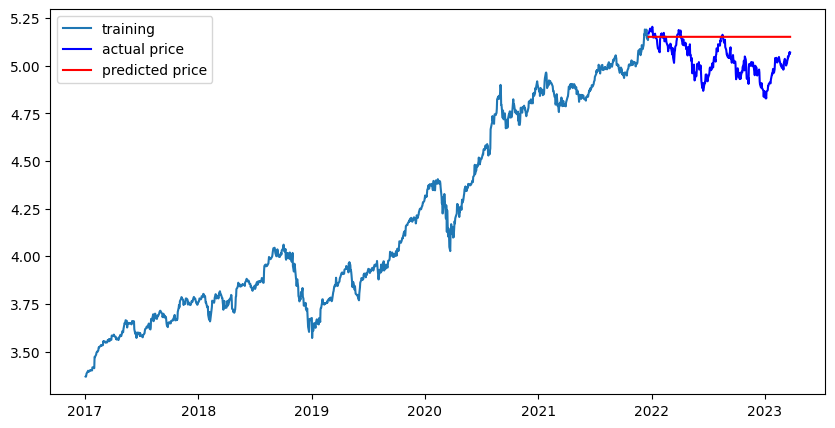

In [191]:
fc = fitted.forecast(len(test_data), alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc.values, index=test_data.index)
# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [192]:
print_logerror(test_data, fc)

MSE:  530.6692356631278
MAE:  19.556880906564853
RMSE:  23.03625915080675
MAPE: 13.49%


조금 증가하는것으로 예측했지만 실제로는 감소했다가 오르는 중이다.

# Amazon

In [194]:
df = fdr.DataReader('AMZN', '1995-01-01')
ts = df['Close']
ts.head()

Date
1997-05-15    0.097917
1997-05-16    0.086458
1997-05-19    0.085417
1997-05-20    0.081771
1997-05-21    0.071354
Name: Close, dtype: float64

In [195]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [196]:
# ts_log = np.log(ts) #값이 작아서 0이 포함되면 안되므로 log를 빼준다

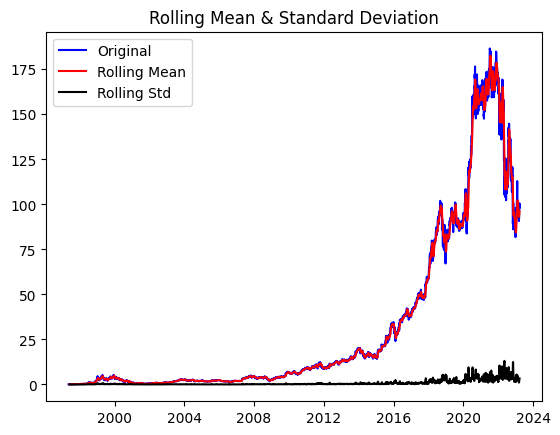

Results of Dickey-Fuller Test:
Test Statistic                   -0.473764
p-value                           0.897035
#Lags Used                       34.000000
Number of Observations Used    6472.000000
Critical Value (1%)              -3.431361
Critical Value (5%)              -2.861987
Critical Value (10%)             -2.567008
dtype: float64


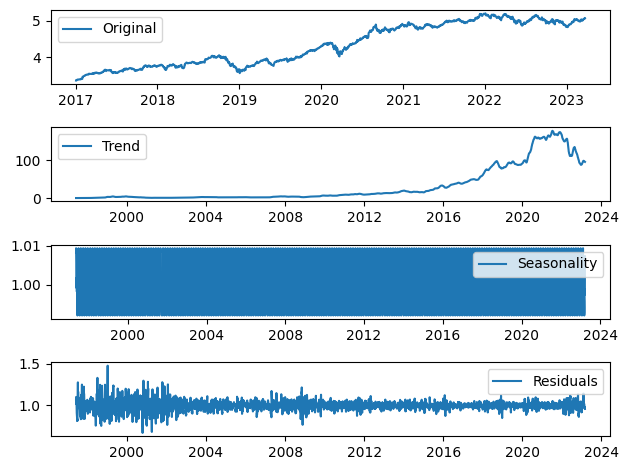

In [197]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

계절성, 트렌드가 확인된다. adf검정 결과도 정상성을 만족하지 못한다.

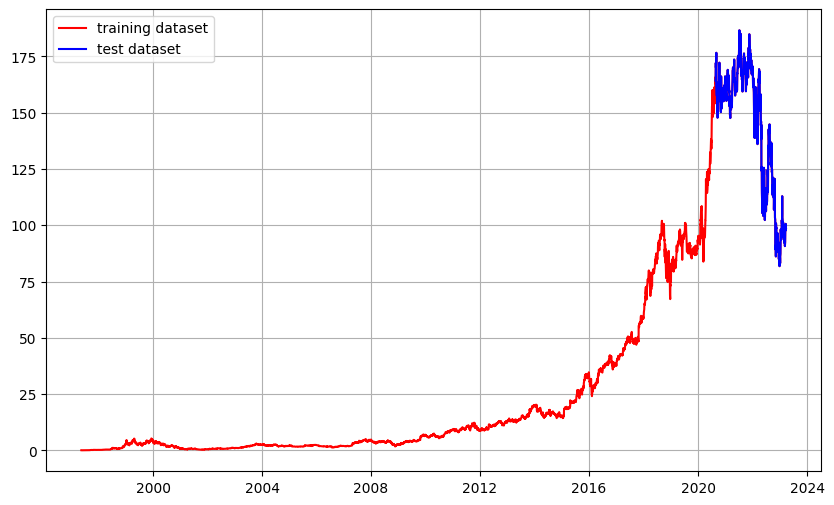

In [198]:
train_data, test_data =  ts[:int(len(ts)*0.9)], ts[int(len(ts)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

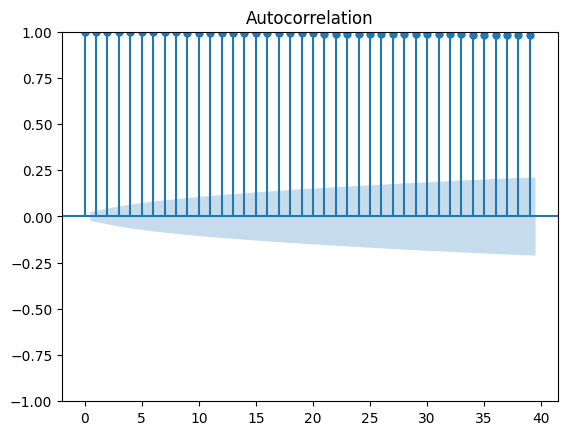

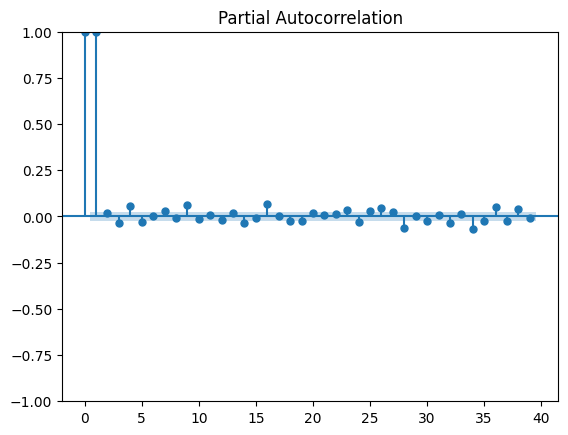

In [199]:
plot_acf(ts)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

autocorrelation이 점진적으로 감소하는 형태이기 때문에 P를 결정할 수 없다.
partial autocorrelation을 봤을때 Q는 2가 적당해 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.235347e+01
p-value                        5.755682e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.556000e+03
Critical Value (1%)           -3.434560e+00
Critical Value (5%)           -2.863399e+00
Critical Value (10%)          -2.567760e+00
dtype: float64


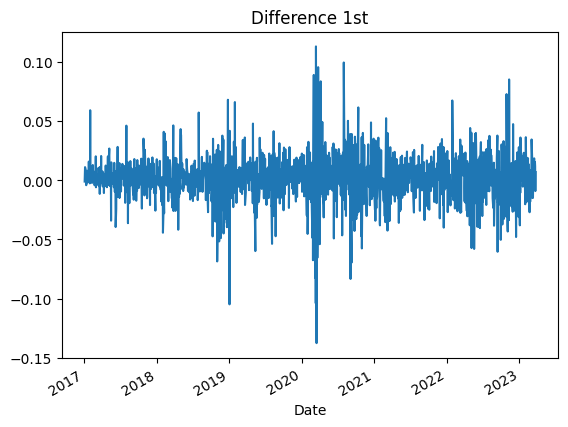

In [201]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

차분 결과 잔차의 정상성이 확인되었다.

In [202]:

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(0,1,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5856
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -6348.028
Date:                Fri, 24 Mar 2023   AIC                          12702.055
Time:                        12:51:35   BIC                          12722.081
Sample:                             0   HQIC                         12709.018
                               - 5856                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0672      0.004    -18.528      0.000      -0.074      -0.060
ma.L2          0.0269      0.003      7.767      0.000       0.020       0.034
sigma2         0.5120      0.002    260.573      0.0

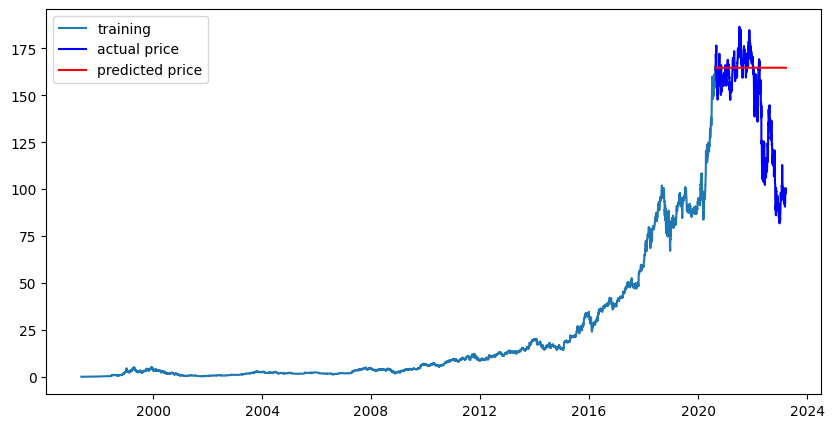

In [203]:
fc = fitted.forecast(len(test_data), alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc.values, index=test_data.index)
# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [206]:
print_error(test_data, fc)

MSE:  1236.1668323692063
MAE:  24.35705597253918
RMSE:  35.15916427290624
MAPE: 22.05%


train 데이터의 기간동안 계속 올랐어서 주식의 하락을 잘 예측하지 못한다.

# Kakao

In [222]:
df = fdr.DataReader('035720', '2017')
ts = df['Close']
ts.head()

Date
2017-01-02    15394
2017-01-03    16057
2017-01-04    16920
2017-01-05    16860
2017-01-06    16800
Name: Close, dtype: int64

In [223]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: int64)

In [233]:
ts_log = np.log(ts) 

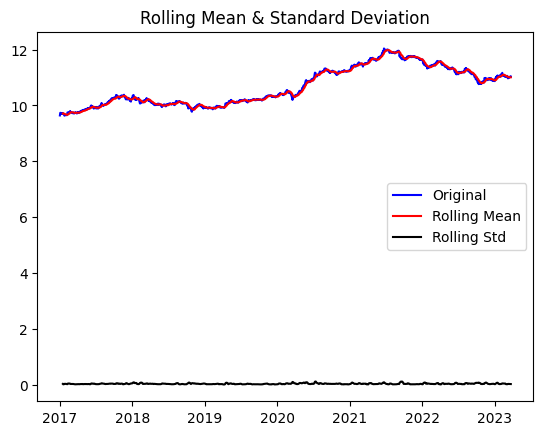

Results of Dickey-Fuller Test:
Test Statistic                   -1.300087
p-value                           0.629132
#Lags Used                        3.000000
Number of Observations Used    1528.000000
Critical Value (1%)              -3.434637
Critical Value (5%)              -2.863433
Critical Value (10%)             -2.567778
dtype: float64


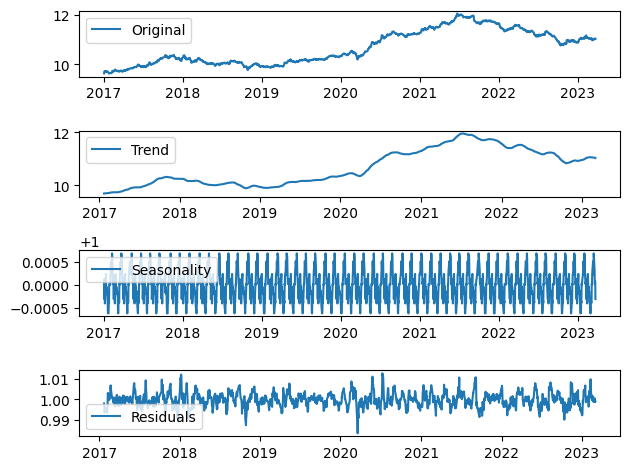

In [234]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

계절성, 트렌드가 확인된다. adf검정 결과도 정상성을 만족하지 못한다.

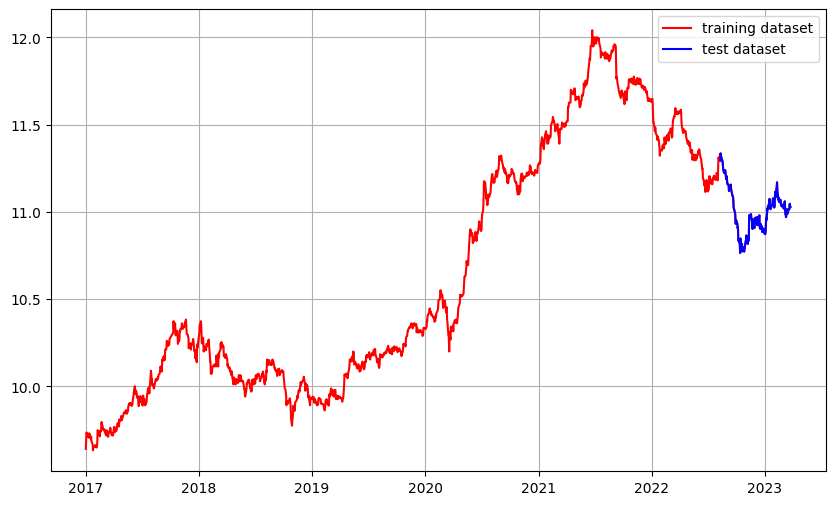

In [235]:
train_data, test_data =  ts_log[:int(len(ts)*0.9)], ts_log[int(len(ts)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

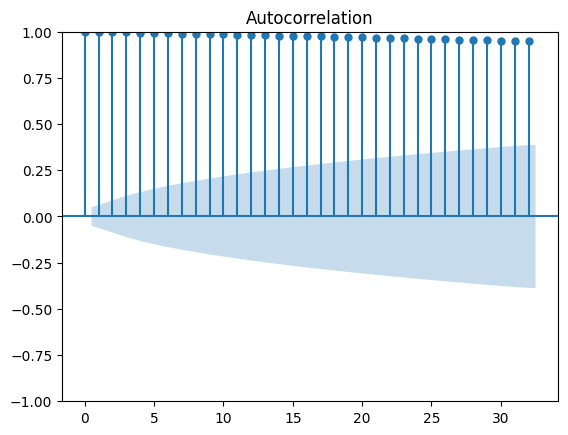

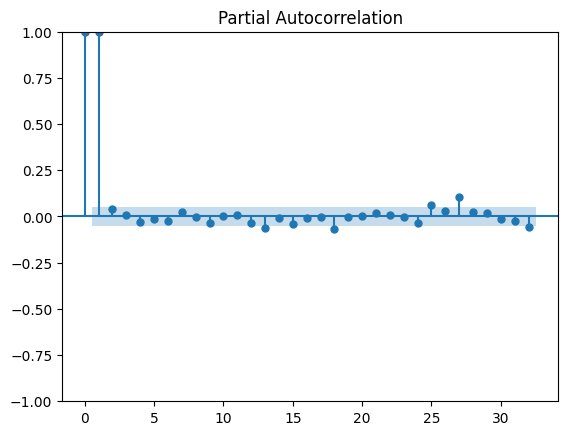

In [236]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

autocorrelation이 점진적으로 감소하는 형태이기 때문에 P를 결정할 수 없다.
partial autocorrelation을 봤을때 Q는 2또는 3이 적당해 보인다.

Results of Dickey-Fuller Test:
Test Statistic                  -21.017709
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1528.000000
Critical Value (1%)              -3.434637
Critical Value (5%)              -2.863433
Critical Value (10%)             -2.567778
dtype: float64


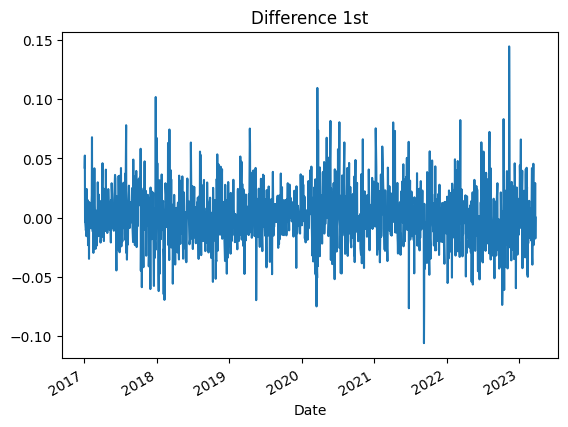

In [237]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

차분 결과 잔차의 정상성이 확인되었다.

In [249]:

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(0,1,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1378
Model:                 ARIMA(0, 1, 2)   Log Likelihood                3242.784
Date:                Fri, 24 Mar 2023   AIC                          -6479.567
Time:                        14:14:37   BIC                          -6463.884
Sample:                             0   HQIC                         -6473.700
                               - 1378                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0158      0.023      0.676      0.499      -0.030       0.061
ma.L2          0.0457      0.024      1.902      0.057      -0.001       0.093
sigma2         0.0005   1.45e-05     36.229      0.0

In [250]:
model2 = ARIMA(train_data, order=(0,1,3))
fitted2 = model2.fit()
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1378
Model:                 ARIMA(0, 1, 3)   Log Likelihood                3243.670
Date:                Fri, 24 Mar 2023   AIC                          -6479.341
Time:                        14:14:40   BIC                          -6458.430
Sample:                             0   HQIC                         -6471.517
                               - 1378                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0179      0.024      0.759      0.448      -0.028       0.064
ma.L2          0.0465      0.024      1.937      0.053      -0.001       0.093
ma.L3          0.0365      0.027      1.357      0.1

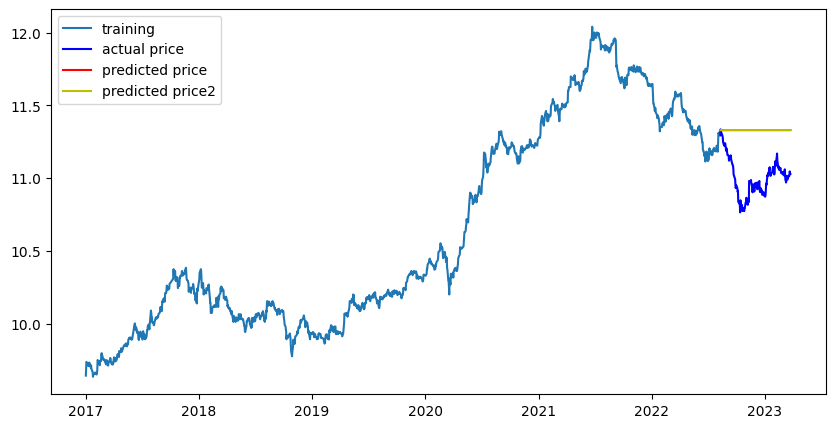

In [251]:
fc = fitted.forecast(len(test_data), alpha=0.05)
fc2 = fitted2.forecast(len(test_data), alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc.values, index=test_data.index)
fc_series2 = pd.Series(fc2.values, index=test_data.index)
# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.plot(fc_series2, c='y',label='predicted price2')
plt.legend()
plt.show()

In [252]:
print_error(test_data, fc)
print_error(test_data, fc2)

MSE:  0.12388316109176745
MAE:  0.3282604355571677
RMSE:  0.35197039803336794
MAPE: 3.00%
MSE:  0.12392157649059822
MAE:  0.3283181716382579
RMSE:  0.35202496572061226
MAPE: 3.00%


MAPE가 3프로로 q=2일때가 성능이 약간 더 좋다. 약간 상승하는것을 예측하긴 했다.

# US/KRW

In [207]:
df = fdr.DataReader('USD/KRW', '1995-01-01')
ts = df['Close']
ts.head()

Date
2003-12-01    1198.400024
2003-12-02    1195.000000
2003-12-03    1192.500000
2003-12-04    1190.099976
2003-12-05    1184.699951
Name: Close, dtype: float64

In [208]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [209]:
ts_log = np.log(ts)

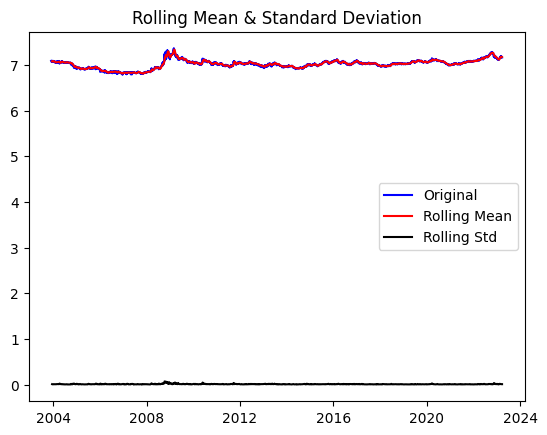

Results of Dickey-Fuller Test:
Test Statistic                   -2.200393
p-value                           0.206103
#Lags Used                       31.000000
Number of Observations Used    5008.000000
Critical Value (1%)              -3.431656
Critical Value (5%)              -2.862117
Critical Value (10%)             -2.567077
dtype: float64


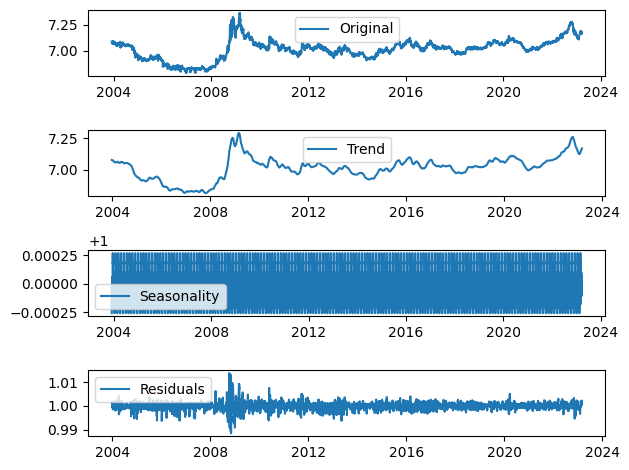

In [210]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

계절성과 트렌드가 어느정도 보이고, adf검정 결과 정상성을 만족하지 못한다.

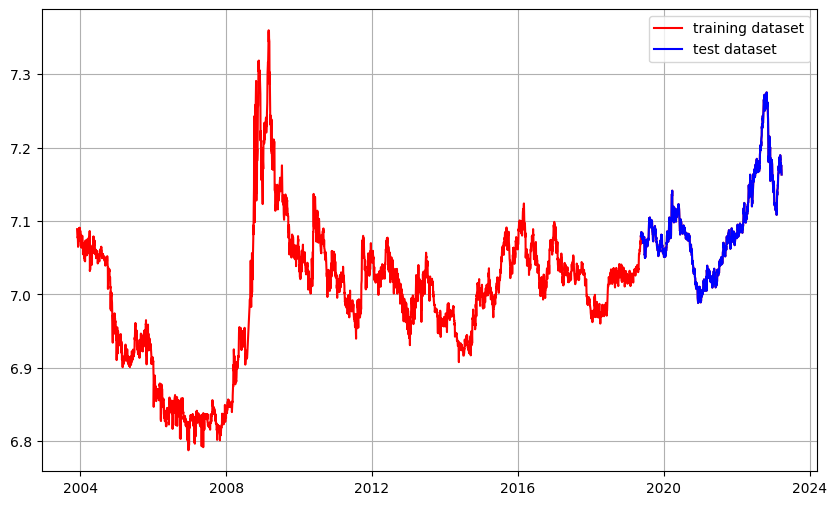

In [211]:
train_data, test_data =  ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

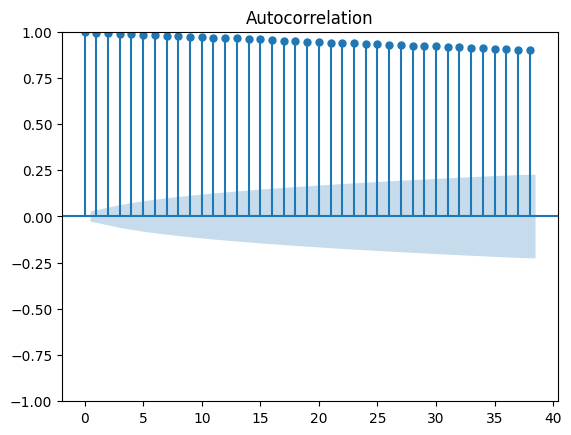

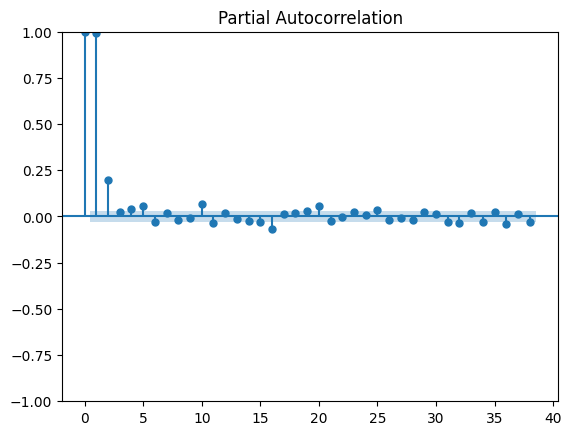

In [212]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

autocorrelation이 점진적으로 감소하는 형태이기 때문에 P를 결정할 수 없다.
partial autocorrelation을 봤을때 Q는 5가 적당해 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.210569e+01
p-value                        1.971433e-22
#Lags Used                     3.200000e+01
Number of Observations Used    5.006000e+03
Critical Value (1%)           -3.431657e+00
Critical Value (5%)           -2.862118e+00
Critical Value (10%)          -2.567077e+00
dtype: float64


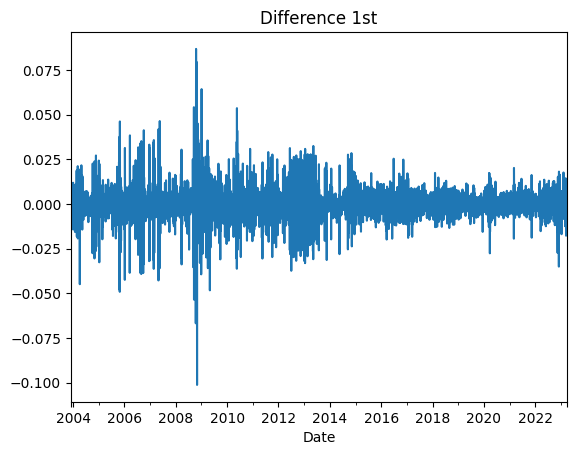

In [220]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

차분 결과 정상성이 확인된다.

In [213]:
model = ARIMA(train_data, order=(0,1,5))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4032
Model:                 ARIMA(0, 1, 5)   Log Likelihood               13160.280
Date:                Fri, 24 Mar 2023   AIC                         -26308.561
Time:                        12:53:58   BIC                         -26270.750
Sample:                    12-01-2003   HQIC                        -26295.163
                         - 05-14-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2254      0.008    -26.769      0.000      -0.242      -0.209
ma.L2         -0.0016      0.010     -0.159      0.874      -0.021       0.018
ma.L3         -0.0509      0.009     -5.441      0.0

In [214]:
model2 = ARIMA(train_data, order=(0,1,3))
fitted2 = model2.fit()
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4032
Model:                 ARIMA(0, 1, 3)   Log Likelihood               13156.422
Date:                Fri, 24 Mar 2023   AIC                         -26304.844
Time:                        12:54:05   BIC                         -26279.637
Sample:                    12-01-2003   HQIC                        -26295.912
                         - 05-14-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2295      0.008    -27.437      0.000      -0.246      -0.213
ma.L2       9.753e-05      0.010      0.010      0.992      -0.019       0.019
ma.L3         -0.0507      0.008     -6.327      0.0

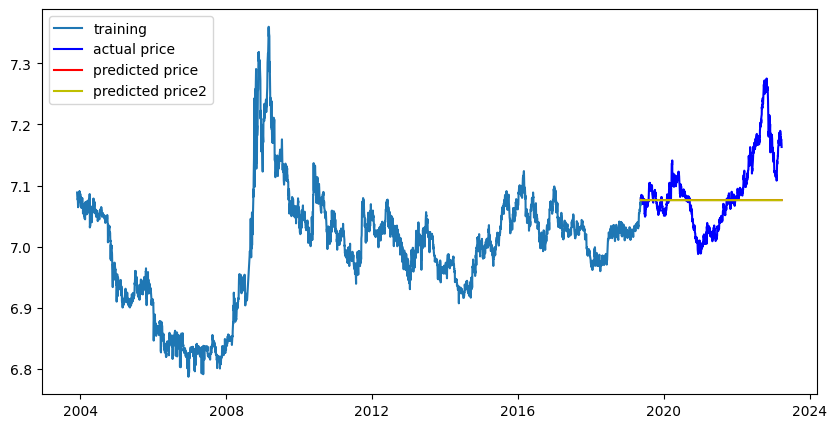

In [218]:
fc = fitted.forecast(len(test_data), alpha=0.05)
fc2 = fitted2.forecast(len(test_data), alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc.values, index=test_data.index)
fc_series2 = pd.Series(fc2.values, index=test_data.index)
# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.plot(fc_series2, c='y',label='predicted price2')
plt.legend()
plt.show()

In [219]:
print_logerror(test_data, fc)
print_logerror(test_data, fc2)

MSE:  6048.178666777561
MAE:  54.38531273189289
RMSE:  77.77003707584021
MAPE: 4.36%
MSE:  6059.672083650853
MAE:  54.42634206579404
RMSE:  77.8438956094237
MAPE: 4.36%


추세는 어느정도 예측을 했고 q값이 5일때가 성능이 좀더 좋다.